# Data Curation
To train a machine learning model from data, that data must first be "curated" to ensure that chemical structures 
and properties are represented consistently.
Curating raw data is a long, detailed process that takes several steps.
[SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) strings need to be standardized, measurements
need to be converted to common units, outliers need to be removed or corrected, 
and replicates need to be combined. These steps are vital to create datasets that
can be used to train useful predictive models. 
Here we will cover some functions in [AMPL](https://github.com/ATOMScience-org/AMPL) that will help
you to perform these steps.

- [base_smiles_from_smiles](https://ampl.readthedocs.io/en/latest/utils.html#utils.struct_utils.base_smiles_from_smiles)
- [mol_wt_from_smiles](https://ampl.readthedocs.io/en/latest/utils.html#utils.struct_utils.mol_wt_from_smiles)
- [standardize_relations](https://ampl.readthedocs.io/en/latest/utils.html#utils.data_curation_functions.standardize_relations)
- [compute_negative_log_responses](https://ampl.readthedocs.io/en/latest/utils.html#utils.data_curation_functions.compute_negative_log_responses)
- [remove_outlier_replicates](https://ampl.readthedocs.io/en/latest/utils.html#utils.curate_data.remove_outlier_replicates)
- [aggregate_assay_data](https://ampl.readthedocs.io/en/latest/utils.html#utils.curate_data.aggregate_assay_data)

These are just a few of the steps needed to curate a dataset;
another tutorial will cover data curation in more detail.

## Import Standard Data Science Packages
To use [AMPL](https://github.com/ATOMScience-org/AMPL), or to do almost anything else with data, you'll need to become familiar with the popular packages 
[pandas](https://pandas.pydata.org/), 
[numpy](https://numpy.org/), 
[matplotlib](https://matplotlib.org/) and 
[seaborn](https://seaborn.pydata.org/index.html). 
When you installed AMPL you will have installed these packages as well, so you simply need to import them here.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read the Data
We've prepared an example dataset containing [$IC_{50}$](https://en.wikipedia.org/wiki/IC50) values for inhibitors of 
the [KCNA3](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL4633/) 
potassium channel collected from [ChEMBL](https://www.ebi.ac.uk/chembl/). This dataset is 
simpler than most that we find in the wild, but it will let us concisely 
demonstrate some AMPL curation tools. The first step of data curation is to read the dataset into a Pandas data frame.

In [2]:
# Read in data
kcna3 = pd.read_csv('dataset/kcna3_ic50.csv')

In [3]:
# Check the number of rows and columns in the dataset
kcna3.shape

(891, 6)

In [4]:
# List the column names
kcna3.columns.values

array(['molecule_chembl_id', 'smiles', 'standard_type',
       'standard_relation', 'standard_value', 'standard_units'],
      dtype=object)

This dataset is drawn from the ChEMBL database and contains the following columns:
- `molecule_chembl_id`: The ChEMBL ID for the molecule.
- `smiles`: The SMILES string that represents the molecule's structure. This is the main
input used to derive features for [AMPL](https://github.com/ATOMScience-org/AMPL) models.
- `standard_type`: The type of measurement, e.g., $IC_{50}$, $K_i$, $K_d$, etc.
This dataset only contains $IC_{50}$ data points.
- `standard_relation`: The relational operator for a measurement reported as "< $X$" or "> $X$", indicating the true value is below or above some limit $X$ (e.g., the lowest or highest concentration tested). When this occurs we say the measurement is "left-" or "right-censored".
- `standard_value`: The measured value (or the limit value for a censored measurement).
- `standard_units`: The units of the measurement. $IC_{50}$ values may be recorded in different units which will need to be converted to a common unit. The KCNA3 dataset uses nanomolar (nM) units exclusively, but other datasets we'll work with may contain a mixture of nanomolar and micromolar (µM or uM) units.

## Standardize SMILES
The SMILES grammar allows the same chemical structure to be represented by many different SMILES strings. In addition, measurements may be performed on compounds with different salt groups or with radioisotope labels, which we treat as equivalent to the base compounds. AMPL provides a SMILES standardization function, `base_smiles_to_smiles`, that removes salt groups and isotopes and returns a unique SMILES string for each base compound structure. This step simplifies the machine learning problem by ensuring each compound is represented with the same set of features and multiple measurements on the same compound can be grouped together. 

> **Note:** *The input to base_smiles_from_smiles must be a `list`; `numpy` arrays and `pandas` Series objects must be converted with the `tolist` function.*

In [5]:
from atomsci.ddm.utils.struct_utils import base_smiles_from_smiles
# Since the base_smiles_from_smiles function can be slow, we specify the workers=8 argument
# to divide the work across 8 threads.
kcna3['base_rdkit_smiles'] = base_smiles_from_smiles(kcna3.smiles.tolist(), workers=8)

In [6]:
kcna3.smiles.nunique(), kcna3.base_rdkit_smiles.nunique()

(515, 515)

For this dataset there are 515 unique SMILES that are standardized to 515 unique base SMILES (though some differ from the originals). In other datasets it is common for two different SMILES to be standardized to the same value. From now on we will use `base_rdkit_smiles` to represent compound structures.

## Filter by Molecular Weight
Generally speaking, it is difficult to train models that work well for both small drug-like molecules and large ones.
It turns out that about half the data points in the raw KCNA3 dataset are from peptides, with molecular weights around 4000, all from one study;
the rest are "normal" compounds with molecular weights well below 2000. In order to allow our models to learn predictive features that are relevant
for small molecules, we will compute molecular weights and filter out compounds with MW > 2000.

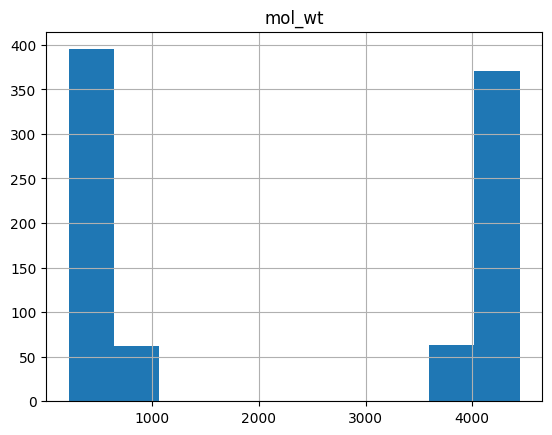

In [7]:
from atomsci.ddm.utils.struct_utils import mol_wt_from_smiles
kcna3['mol_wt'] = mol_wt_from_smiles(kcna3.base_rdkit_smiles.tolist(), workers=8)
_ = kcna3[['mol_wt']].hist()

In [8]:
kcna3 = kcna3[kcna3.mol_wt < 2000].copy()
print(f"After filtering on molecular weight, {len(kcna3)} rows remain with {kcna3.base_rdkit_smiles.nunique()} unique compounds")

After filtering on molecular weight, 457 rows remain with 371 unique compounds


## Calculate $pIC_{50}$'s
An $IC_{50}$ is the concentration of a compound that inhibits a target protein's function by 50%.  Like many other chemical properties, $IC_{50}$ values may span several orders of magnitude, from picomolar to millimolar (a billion-fold range). This makes it difficult to fit machine learning models to them because the variance of repeat measurements grows with the measured value, as shown in the left hand plot below. We prefer to work instead with $pIC_{50}$ values, where $pIC_{50} = -\mathrm{log}_{10} (IC_{50})$ with $IC_{50}$ in molar units, because the log transformed measurements have more stable variances, as shown at right. Similar transformations are often applied to properties like $K_i$'s, $K_d$'s
and $EC_{50}$'s, yielding $pK_i$'s, $pK_d$'s, and $EC_{50}$'s.

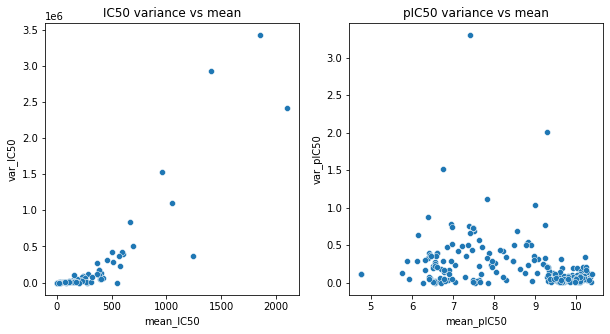

> **Note**:
> For those who want more details: It's hard to fit ML models to raw $IC_{50}$'s because typical training methods seek to minimize a squared-error loss function (the error being the difference between the actual and predicted values). Squared errors tend to scale with the variance among replicates, so the loss function is dominated by the compounds with the largest variance, i.e. those with the largest $IC_{50}$'s. This leads to models that perform OK on the least potent compounds and terribly on the most potent.

The AMPL function `compute_negative_log_responses` performs these variance stabilizing transformations, converting $IC_{50}$'s to $pIC_{50}$'s and so on. The code below uses the 
units in the `standard_units` column and the conversion functions specified 
in the `unit_conv` argument to convert the $IC_{50}$'s in the `standard_value` column to molar units before applying the log transformation. It also inverts the "<" and ">" operators in `relation_col` so that they correctly 
describe the $pIC_{50}$ values, which *decrease* as $IC_{50}$ values *increase* (e.g., "$IC_{50} > 100 \mathrm{uM}$" means "$IC_{50} > 10^{-4} \mathrm{M}$" which implies "$pIC_{50} < 4$").

In [9]:
from atomsci.ddm.utils.data_curation_functions import compute_negative_log_responses 
kcna3 = compute_negative_log_responses(kcna3, 
                              unit_col='standard_units',
                              value_col='standard_value',
                              new_value_col='pIC50',
                              relation_col='standard_relation',
                              unit_conv={'µM':lambda x: x*1e-6, 'nM':lambda x: x*1e-9},
                              inplace=False)

We then plot histograms to compare the distributions of the raw and transformed $IC_{50}$'s:

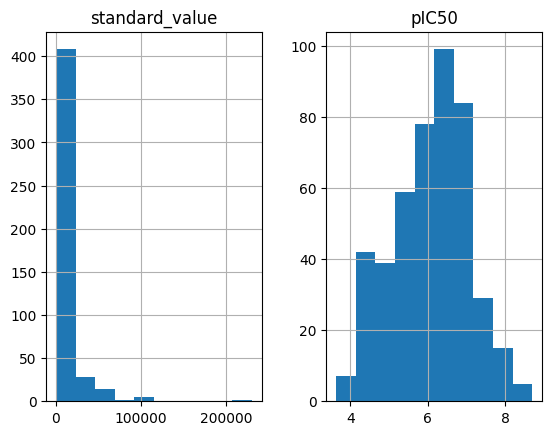

In [10]:
_ = kcna3[['standard_value', 'pIC50']].hist()

## Standardize Relations
Some databases may contain measurements reported with a variety of relational operators such as ">=", "<=", "~" and so on. In datasets used to train models, AMPL expects the relation column to contain one of the three standard operators ">", "<" or "=", or an empty field representing equality. [AMPL](https://github.com/ATOMScience-org/AMPL) provides a `standardize_relations` function to coerce nonstandard relations to one of the standard values. We use the `rel_col` and `output_rel_col` arguments to indicate that the input relations are in the `standard_relation` column, and to specify a new column to receive the standardized relations.  The `db=ChEMBL` argument tells the function to apply ChEMBL-specific formatting changes (such as removing quotes around operators).

In [11]:
from atomsci.ddm.utils.data_curation_functions import standardize_relations
kcna3 = standardize_relations(kcna3, 
                    rel_col='standard_relation', db='ChEMBL',
                    output_rel_col='fixed_relation')

In [12]:
# Look at the operator counts before and after standardization
kcna3.standard_relation.value_counts()

standard_relation
'='    407
'<'     48
'>'      2
Name: count, dtype: int64

In [13]:
kcna3.fixed_relation.value_counts()

fixed_relation
=    407
<     48
>      2
Name: count, dtype: int64

For this dataset, we see that there were no nonstandard operators, but the single quotes around the operators were removed, as we requested.

## Remove Outliers and Aggregate Replicate Measurements
The final step is to remove outliers and aggregate (average) replicate measurements on the same compounds. The function `remove_outlier_replicates` is a simple filter that groups measurements by compound, computes the median of each group, and removes values that differ more than `max_diff_from_median` units from the median. When the measurements are very spread out relative to `max_diff_from_median`, *all* the rows for a compound may be deleted from the dataset. The default setting (1.0) generally works well for $pIC_{50}$ values.

The function `aggregate_assay_data` replaces multiple replicate measurements for each compound with a single aggregate value. Usually this is simply the average over the replicates, but if the dataset contains both censored and uncensored values for a compound, the function computes a maximum likelihood estimate that takes the censoring into account.


In [14]:
from atomsci.ddm.utils.curate_data import remove_outlier_replicates, aggregate_assay_data

kcna3_cur = remove_outlier_replicates(kcna3, id_col='molecule_chembl_id',
                                response_col='pIC50',
                                max_diff_from_median=1.0)

kcna3_cur = aggregate_assay_data(kcna3_cur, 
                             value_col='pIC50',
                             output_value_col='avg_pIC50',
                             id_col='molecule_chembl_id',
                             smiles_col='base_rdkit_smiles',
                             relation_col='fixed_relation',
                             label_actives=False,
                             verbose=True
                        )
print("Original data shape: ", kcna3.shape)
print("Curated data shape: ", kcna3_cur.shape)
kcna3_cur.head()

Removed 4 pIC50 replicate measurements that were > 1.0 from median
0 entries in input table are missing SMILES strings
370 unique SMILES strings are reduced to 370 unique base SMILES strings
Original data shape:  (457, 10)
Curated data shape:  (370, 4)


,compound_id,base_rdkit_smiles,relation,avg_pIC50
0,CHEMBL416538,C/C=C/C(=O)N[C@H]1CC[C@@](CNC(=O)c2ccccc2OC)(c...,,6.356547
1,CHEMBL277064,C/C=C/C(=O)N[C@H]1CC[C@](CNC(=O)c2ccccc2OC)(c2...,,6.699514
2,CHEMBL57615,C/N=c1\ccn(Cc2ccccc2)c2cc(Cl)ccc12,<,5.301030
3,CHEMBL280102,C=C(C)CNC(=O)O[C@H]1CC[C@@](CNC(=O)c2ccccc2OC)...,,6.604085
4,CHEMBL16961,C=C(C)CNC(=O)O[C@H]1CC[C@](CNC(=O)c2ccccc2OC)(...,,6.920819


The data frame returned by `aggregate_assay_data` contains only four columns:
- `compound_id`, a unique ID for each base SMILES string. When multiple values are found in `id_col` for the same SMILES string, the function assigns it the first one in lexicographic order.
- `base_rdkit_smiles`, the standardized SMILES string.
- `relation`, an *aggregate* relation for the set of replicates.
- `avg_pIC50`, or whatever you specified in the `output_value_col` argument, containing the aggregate/average $pIC_{50}$ value.

> **Note** 
> When the `label_actives` argument is True (the default), an additional column `active` is added for use in training classification models. We will cover
classification models in a future tutorial.

Finally, we save the curated dataset to a CSV file. 

In [15]:
kcna3_cur.to_csv('dataset/curated_kcna3_ic50.csv', index=False)

In the next tutorial, we'll show how to split this dataset into training, validation and test
sets for model training.